# LIGO Data Analysis

In this lab, we analyse the data recorded by LIGO in its initial GW150914 graivtional wave signal detection to better understand how to identify and remove noise sources from data.

## 1. Importing Data and Libraries

In [160]:
import scipy.fft as fft
import scipy.signal as sig
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from IPython.display import Audio

matplotlib.rcParams['text.usetex'] = True

In [2]:
def get_data(filename):
          data = []
          with open(filename, 'r') as datafile:
              NaNs = 0
              for line in datafile:
                  if line[0] == '#':
                      print(line[:-1])
                  else:
                      try: data += [float(line)]
                      except ValueError: NaNs += 1
              if NaNs > 0:
                  print('Warning:\n ', NaNs, 'lines couldn\'t be read as numbers\n')
          return np.array(data)

In [3]:
H1_data = get_data("H-H1_GWOSC_4KHZ_R1-1126259447-32.txt")
L1_data = get_data("L-L1_GWOSC_4KHZ_R1-1126259447-32.txt")

sample_time = len(H1_data)/4096
num_samples = len(H1_data)

print("Sample time: " + str(sample_time))
print("Number samples: " + str(num_samples))

# Gravitational wave strain for GW150914_R1 for H1 (see http://losc.ligo.org)
# This file has 4096 samples per second
# starting GPS 1126259447 duration 32
# Gravitational wave strain for GW150914_R1 for L1 (see http://losc.ligo.org)
# This file has 4096 samples per second
# starting GPS 1126259447 duration 32
Sample time: 32.0
Number samples: 131072


## 2a Plotting Data Sets for Both Detectors

We use the typical matplotlib library to plot the data.

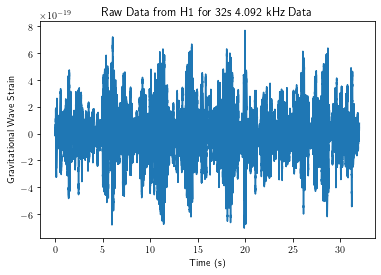

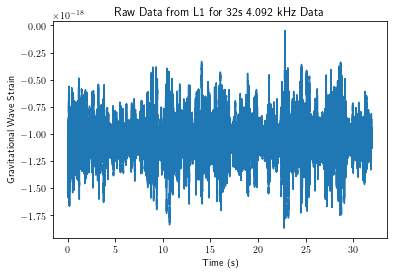

In [4]:
time_for_raw_data = np.linspace(0, sample_time, num_samples)

plot1 = plt.figure(1)
line = plt.plot(time_for_raw_data, H1_data)
plt.title("Raw Data from H1 for 32s 4.092 kHz Data")
plt.ylabel("Gravitational Wave Strain")
plt.xlabel("Time (s)")
plt.show()

plot2 = plt.figure(2)
line = plt.plot(time_for_raw_data, L1_data)
plt.title("Raw Data from L1 for 32s 4.092 kHz Data")
plt.ylabel("Gravitational Wave Strain")
plt.xlabel("Time (s)")
plt.show()

## 2b Plotting Fourier Transform

In [5]:
# Generate a frequency axis using the inbuilt function
freq_axis = fft.rfftfreq(num_samples, 1/4096)

# Since our data is real, we take the real Fourier transform using SciPy's rfft function.
H1_data_raw_rfft = fft.rfft(H1_data)
L1_data_raw_rfft = fft.rfft(L1_data)

# We take the absolute values to plot a more realistic transform 
abs_H1_data_raw_rfft = abs(H1_data_raw_rfft)
abs_L1_data_raw_rfft = abs(L1_data_raw_rfft)

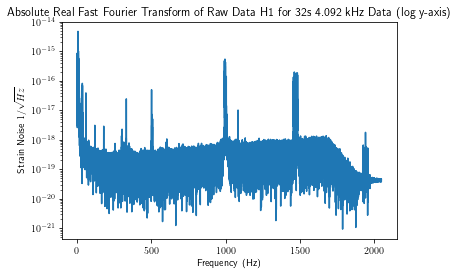

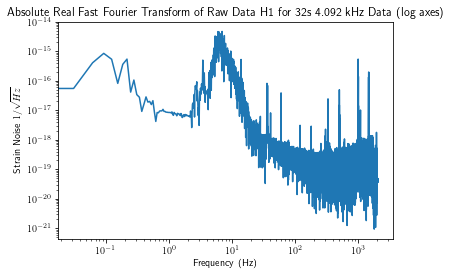

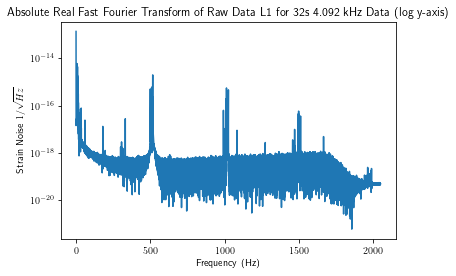

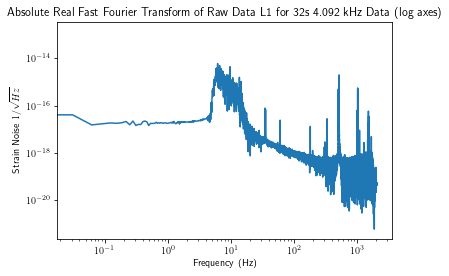

In [6]:
plot3 = plt.figure(3)
line = plt.plot(freq_axis, abs_H1_data_raw_rfft)
plt.title("Absolute Real Fast Fourier Transform of Raw Data H1 for 32s 4.092 kHz Data (log y-axis)")
plt.xlabel("Frequency (Hz)")
plt.yscale("log")
plt.ylabel("Strain Noise $1/\sqrt{Hz}$")
plt.show()

plot4 = plt.figure(4)
line = plt.plot(freq_axis, abs_H1_data_raw_rfft)
plt.title("Absolute Real Fast Fourier Transform of Raw Data H1 for 32s 4.092 kHz Data (log axes)")
plt.xscale("log")
plt.xlabel("Frequency (Hz)")
plt.yscale("log")
plt.ylabel("Strain Noise $1/\sqrt{Hz}$")
plt.show()

plot5 = plt.figure(5)
line = plt.plot(freq_axis, abs_L1_data_raw_rfft)
plt.title("Absolute Real Fast Fourier Transform of Raw Data L1 for 32s 4.092 kHz Data (log y-axis)")
plt.xlabel("Frequency (Hz)")
plt.yscale("log")
plt.ylabel("Strain Noise $1/\sqrt{Hz}$")
plt.show()

plot6 = plt.figure(6)
line = plt.plot(freq_axis, abs_L1_data_raw_rfft)
plt.title("Absolute Real Fast Fourier Transform of Raw Data L1 for 32s 4.092 kHz Data (log axes)")
plt.xscale("log")
plt.xlabel("Frequency (Hz)")
plt.yscale("log")
plt.ylabel("Strain Noise $1/\sqrt{Hz}$")
plt.show()

These plots look similar to the ones produced in (https://iopscience.iop.org/article/10.1088/1361-6382/ab685e#cqgab685es2) and thus we have confidence in the method used. Indeed, the same peaks occur around 250, 500 and 1000 Hz as in figure 2 of the paper. We also see the same general shape as in the paper, with higher strain noise at lower frquencies and a relatively consant noise trend with periodic peaks between 100 and 2000 Hz for all graphs.

## 3i Function Returning Two-Seocnd Chunks of Data

To whiten the nouse we first write a function which reutrns a two-second long chunk of data starting from an arbitrary time. Say t=4,5,6...

In [7]:
def twoSecondChunk(t_start, data):
    
    # Converts time into sample start
    sample_start = int(t_start * 4096)
    
    # If sample start is within the appropriate range, returns the requist data
    if sample_start <= num_samples - 4096*2 and sample_start >= 0:
        sample_end = sample_start + 4096*2
        return data[sample_start:sample_end]
    
    # If not within range, returns None
    else:
        return None

## 3ii Chunking Data

We chunk the data into a list of 31 entries using the above function where we iterate every second such that for each two second bucket there is an overlap of a second with the next bucket.

In [8]:
chunked_H1_data = []
chunked_L1_data = []

for t in range(0,int(sample_time-1)):
    chunked_H1_data.append(twoSecondChunk(t, H1_data))
    chunked_L1_data.append(twoSecondChunk(t, L1_data))

## 3iii Applying the Tukey Window

We apply a Tukey window to each chunk in order to filter out data near the edges of each chunk. This is to avoid artefacts. We do so by iterating of the chunked lists and use the scipy function sig.windows.tukey. 

In [9]:
# Tukey array with number of samples for each two second chunk.
tukey_array = sig.windows.tukey(4096*2)

tukey_chunked_H1_data = []
tukey_chunked_L1_data = []

for chunk in chunked_H1_data:
    tukey_chunked_H1_data.append(chunk * tukey_array)

for chunk in chunked_L1_data:
    tukey_chunked_L1_data.append(chunk * tukey_array)

## 3iv Applying Fourier Transform to Each Chunk and Average Noise

We apply a real fast fourier transform to each chunk in order to find the average noise in each frequency bin.

In [85]:
tukey_chunked_rfft_H1_data = []
tukey_chunked_rfft_L1_data = []

for tukey_chunk in tukey_chunked_H1_data:
    tukey_chunked_rfft_H1_data.append(fft.rfft(tukey_chunk))

for tukey_chunk in tukey_chunked_L1_data:
    tukey_chunked_rfft_L1_data.append(fft.rfft(tukey_chunk))

In [113]:
freq_bin_average_rfft_H1_data = []
freq_bin_average_rfft_L1_data = []

for freq_bin in range(len(tukey_chunked_rfft_H1_data[0])):
    average = 0
    for chunk in tukey_chunked_rfft_H1_data:
        average += abs(chunk[freq_bin])
    freq_bin_average_rfft_H1_data.append(average / len(tukey_chunked_rfft_H1_data))
    
    average = 0
    
    for chunk in tukey_chunked_rfft_L1_data:
        average += abs(chunk[freq_bin])
    freq_bin_average_rfft_L1_data.append(average / len(tukey_chunked_rfft_L1_data))

## 3v Dividing Chunks and Finding Inverse

In [114]:
normalised_tukey_chunked_rfft_H1_data = []
normalised_tukey_chunked_rfft_L1_data = []

for chunk in tukey_chunked_rfft_H1_data:
    new_chunk = []
    for i, freq_bin_value in enumerate(chunk):
        new_chunk.append(freq_bin_value/freq_bin_average_rfft_H1_data[i])
    normalised_tukey_chunked_rfft_H1_data.append(new_chunk)

for chunk in tukey_chunked_rfft_L1_data:
    new_chunk = []
    for i, freq_bin_value in enumerate(chunk):
        new_chunk.append(freq_bin_value/freq_bin_average_rfft_L1_data[i])
    normalised_tukey_chunked_rfft_L1_data.append(new_chunk)

In [115]:
def inverse_chunks(H1_chunks, L1_chunks):
    
    inverse_normalised_tukey_chunked_rfft_H1_data = []
    inverse_normalised_tukey_chunked_rfft_L1_data = []
    
    for chunk in normalised_tukey_chunked_rfft_H1_data:
        inverse_transform_chunk = fft.irfft(chunk)
        inverse_normalised_tukey_chunked_rfft_H1_data.append(inverse_transform_chunk)

    for chunk in normalised_tukey_chunked_rfft_L1_data:
        inverse_transform_chunk = fft.irfft(chunk)
        inverse_normalised_tukey_chunked_rfft_L1_data.append(inverse_transform_chunk)
    
    return inverse_normalised_tukey_chunked_rfft_H1_data, inverse_normalised_tukey_chunked_rfft_L1_data

In [116]:
print(len(inverse_normalised_tukey_chunked_rfft_H1_data[0]))

8192


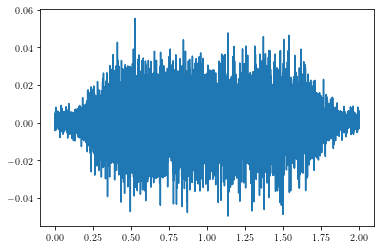

In [117]:
time_axis = np.linspace(0,2, 8192)

inverse_normalised_tukey_chunked_rfft_H1_data, inverse_normalised_tukey_chunked_rfft_L1_data = \
inverse_chunks(normalised_tukey_chunked_rfft_H1_data, normalised_tukey_chunked_rfft_L1_data)

plt.plot(time_axis, inverse_normalised_tukey_chunked_rfft_H1_data[22])
plt.show()

## 4 & 5 Signal FIltering with Butterworth

10


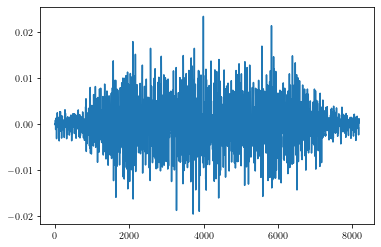

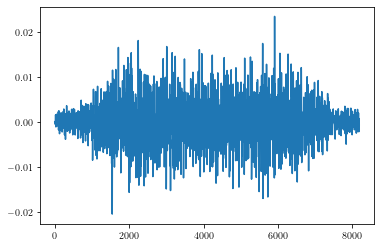

11


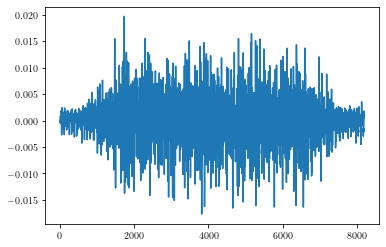

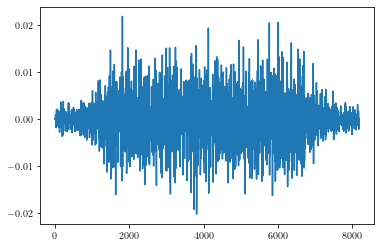

12


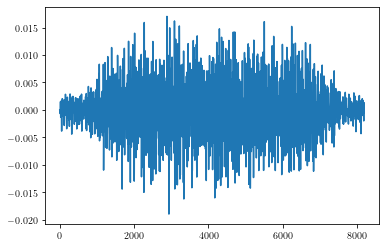

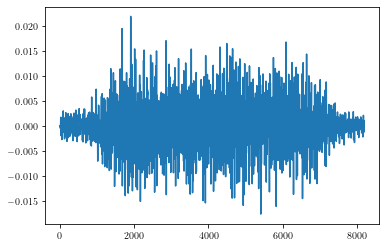

13


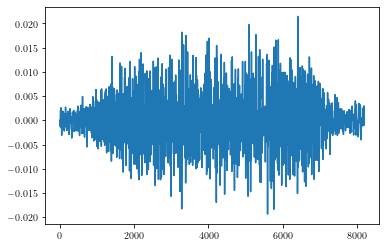

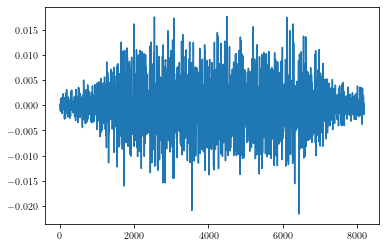

14


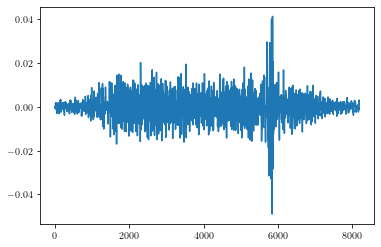

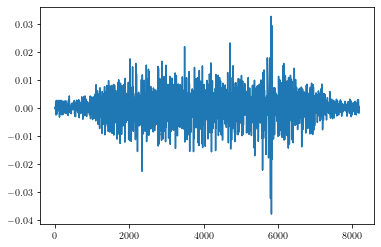

15


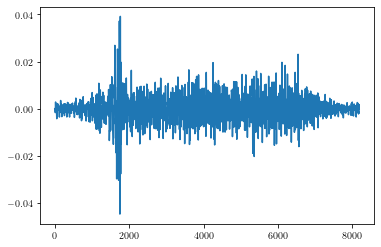

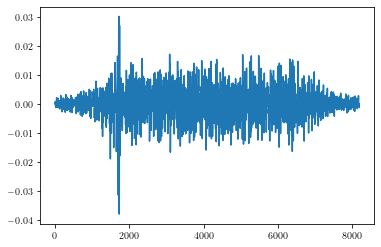

16


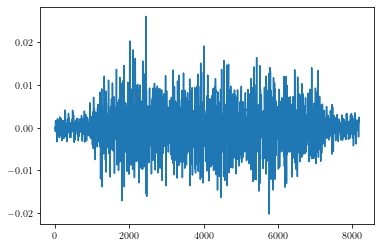

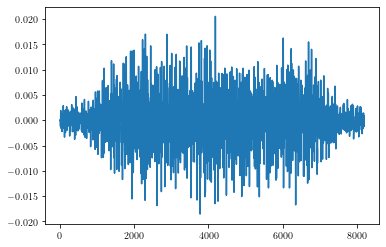

17


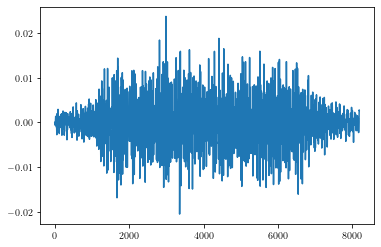

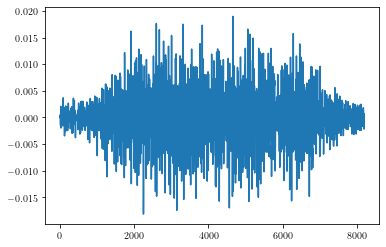

18


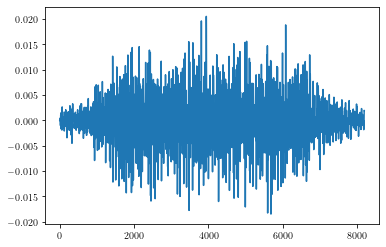

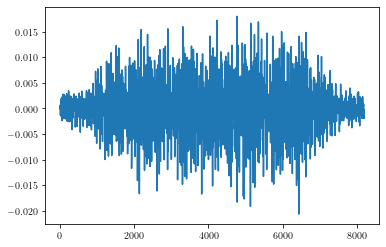

19


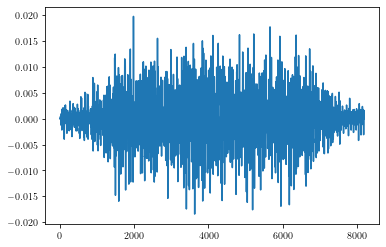

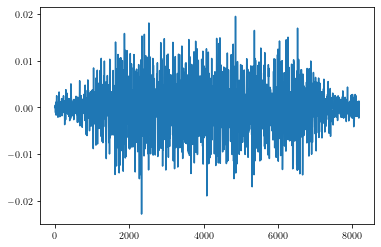

20


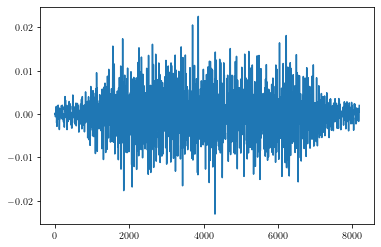

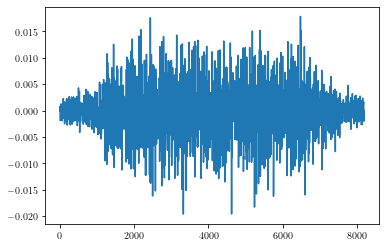

21


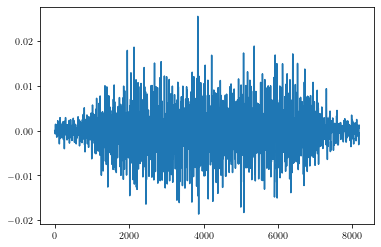

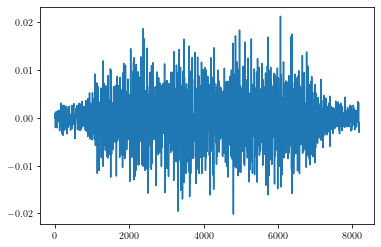

22


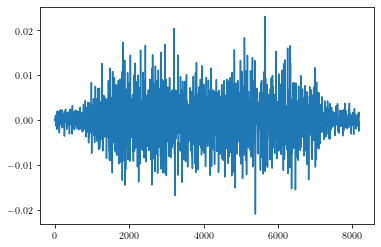

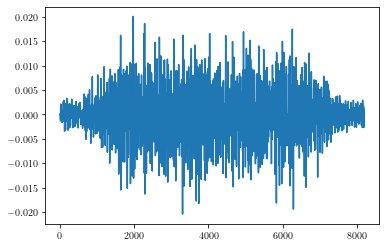

23


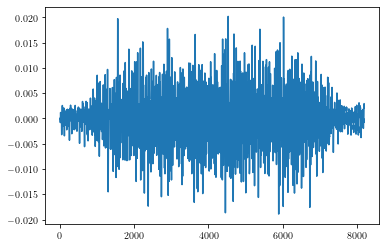

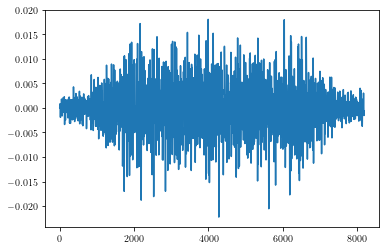

24


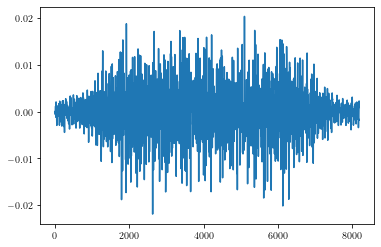

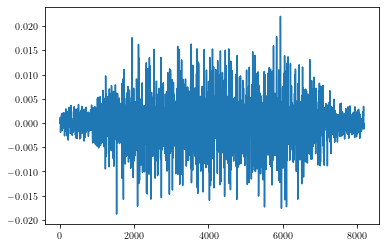

25


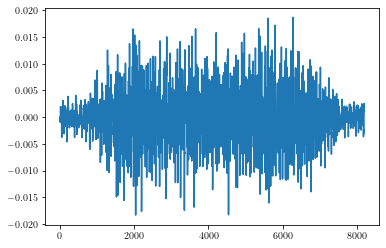

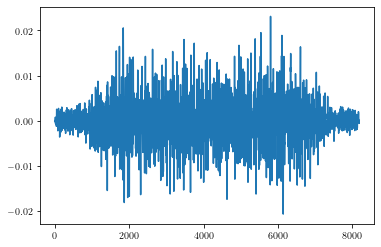

26


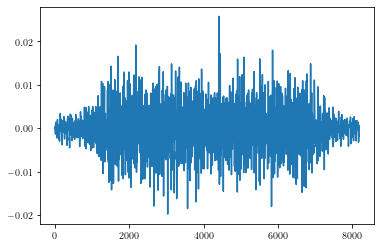

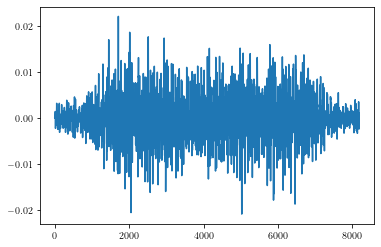

27


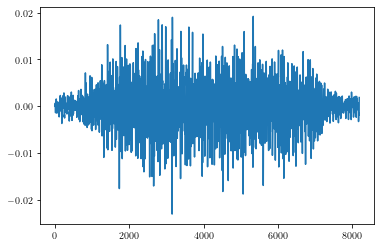

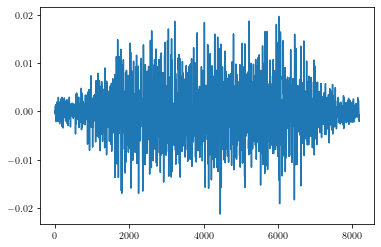

28


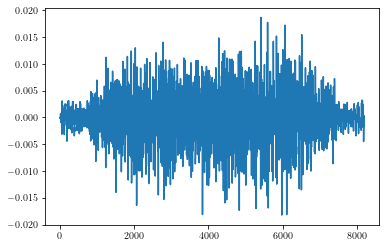

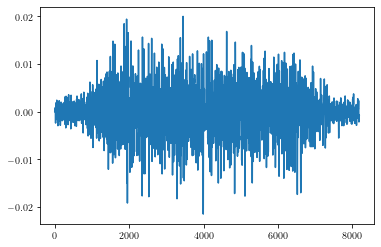

29


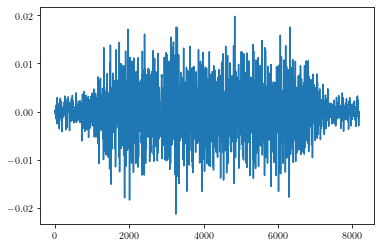

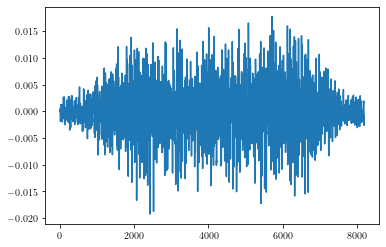

In [119]:
# Creation of Butterworth band-pass filter of order 7 with low 35 Hz, high 350 Hz and sampling frequency 4096.
b, a = sig.butter(7, [35, 350], btype='bandpass', fs=4096)

inverse_butterworth_H1_data, inverse_butterworth_L1_data = inverse_chunks(normalised_tukey_chunked_rfft_H1_data, \
                                                                         normalised_tukey_chunked_rfft_L1_data)

filtered_inverse_butterworth_H1_data = sig.lfilter(b,a,inverse_butterworth_H1_data)
filtered_inverse_butterworth_L1_data = sig.lfilter(b,a,inverse_butterworth_L1_data)

for i in range(0,30):
    print(i)
    plt.plot(time_axis, filtered_inverse_butterworth_H1_data[i])
    plt.show()
    
    plt.plot(time_axis, filtered_inverse_butterworth_L1_data[i])
    plt.show()

We find the signal within the 14th and 15th chunks. We choose the 14th chunk as our reference point and graph the signals from each detector.

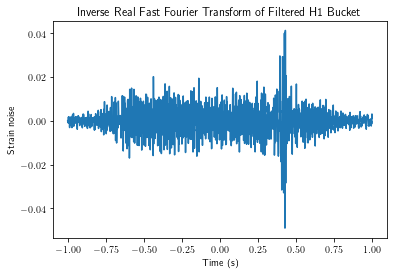

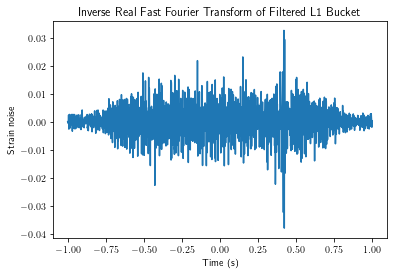

In [120]:
centred_chunk_time_axis = np.linspace(-1,1, 4096*2)

plot7 = plt.figure(7)
line = plt.plot(centred_chunk_time_axis, filtered_inverse_butterworth_H1_data[14])
plt.title("Inverse Real Fast Fourier Transform of Filtered H1 Bucket")
plt.xlabel("Time (s)")
plt.ylabel("Strain noise")
plt.show()

plot8 = plt.figure(8)
line = plt.plot(centred_chunk_time_axis, filtered_inverse_butterworth_L1_data[14])
plt.title("Inverse Real Fast Fourier Transform of Filtered L1 Bucket")
plt.xlabel("Time (s)")
plt.ylabel("Strain noise")
plt.show()

## Generation of Spectrogram

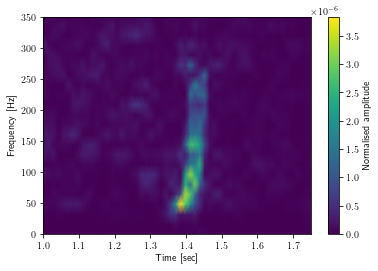

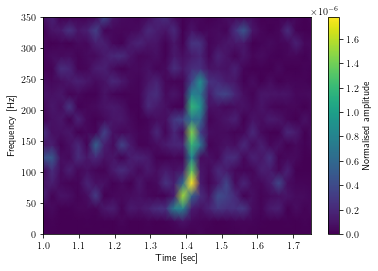

In [183]:
f,t,Sxx = sig.spectrogram(filtered_inverse_butterworth_H1_data[14], 4096, noverlap=200)

plt.pcolormesh(t, f, Sxx, shading='gouraud')
cbar = plt.colorbar()
cbar.set_label('Normalised amplitude', rotation=90)
plt.ylim(0,350)
plt.ylabel('Frequency [Hz]')
plt.xlim(1,1.75)
plt.xlabel('Time [sec]')
plt.show()

f,t,Sxx = sig.spectrogram(filtered_inverse_butterworth_L1_data[14], 4096, noverlap=100, nperseg=200)

plt.pcolormesh(t, f, Sxx, shading='gouraud')
plt.ylim(0,350)
cbar = plt.colorbar()
cbar.set_label('Normalised amplitude', rotation=90)
plt.ylabel('Frequency [Hz]')
plt.xlim(1,1.75)
plt.xlabel('Time [sec]')
plt.show()

## 7 Conversion into a Sound

This sound conversion is quite similar to the one produced by Caltech for their demonstration video: https://www.ligo.caltech.edu/video/ligo20160211v2

In [187]:
Audio(np.real(filtered_inverse_butterworth_L1_data[15]), rate=4096)

## 8 Creating a Matched Filter for the Data

16381


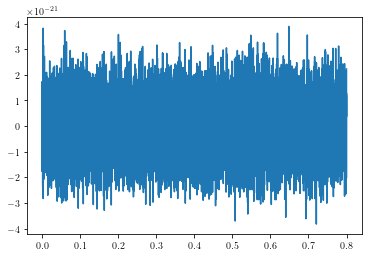

In [218]:
filter_bank_raw_data = np.genfromtxt('gw_ex_data.dat',
                     skip_header=1,
                     skip_footer=1,
                     names=True,
                     dtype='f8',
                     delimiter=' ')

float_filter_bank = []

for (x,y) in filter_bank_raw_data:
    if y != '<f8':
        float_filter_bank.append([x,y])
    else:
        float_filter_bank.append([x,0])

# print(float_filter_bank)
print(len(float_filter_bank))

plt.plot(np.linspace(0,0.8,len(float_filter_bank)), [item[1] for item in float_filter_bank])



16381
16381


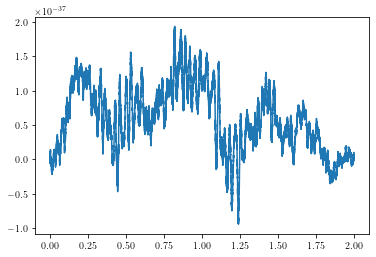

In [226]:
H1_section = H1_data[4096*14:4096*14+16381]
L1_section = L1_data[4096*14:4096*14+16381]

print(len(H1_section))
print(len(L1_section))

H1_correlation = sig.correlate(H1_section, [item[1] for item in float_filter_bank])
L1_correlation = sig.correlate(L1_section, [item[1] for item in float_filter_bank])

plt.plot(np.linspace(0,2,len(float_filter_bank)*2-1), L1_correlation)